In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import numpy as np
import networkx as nx
import ast

In [4]:
#Seed the random number generators:
seed = 1
random.seed(seed)
np.random.seed(seed)

In [9]:
graph = nx.read_graphml('Data/Bratislava_graph.graphml')
coupling_graph = nx.read_graphml('Data/Bratislava_coupling.graphml')
block_data = pd.read_csv('Data/block_info.csv',converters={'Block' : ast.literal_eval})
mean_block_ages = list(block_data['average_age'])
block_sizes = list(block_data['block_size'])
block_names = list(block_data['block_name'])
block_data

,Unnamed: 0,block_name,block_size,average_age
0,0,Okolie_ages_1-17,1234,9.0
1,1,Okolie_ages_18-21,1939,19.5
2,2,Okolie_ages_22-28,3154,25.0
3,3,Okolie_ages_29-112,3458,70.5
4,4,Petrzalka_ages_1-17,1398,9.0
5,5,Petrzalka_ages_18-21,2106,19.5
6,6,Petrzalka_ages_22-28,5234,25.0
7,7,Petrzalka_ages_29-112,4550,70.5
8,8,Ruzinov_ages_1-17,586,9.0
9,9,Ruzinov_ages_18-21,1123,19.5


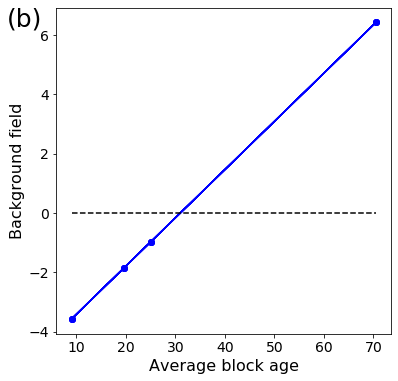

In [10]:
#Add linear field in age:
def linear_field(x : np.ndarray,gradient :float) :
    #Can calibrate to get the average field on individuals close to zero.
    return gradient*x

#Scale ages to [-1,1]:
rescaled_ages = [ (k-np.mean(mean_block_ages))/(max(mean_block_ages)-min(mean_block_ages)) for k in mean_block_ages ]
gradient=10.0 
age_field = [linear_field(a,gradient) for a in rescaled_ages ]

plt.figure(figsize=(6,6))
plt.plot(mean_block_ages,age_field,'bo-')
plt.plot([min(mean_block_ages),max(mean_block_ages)],[0,0],'k--')
plt.xlabel("Average block age",fontsize=16)
plt.ylabel("Background field",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.text(-4,6.3,'(b)',fontsize=25)
plt.savefig("Plots/linear_field_example.jpg",bbox_inches='tight')

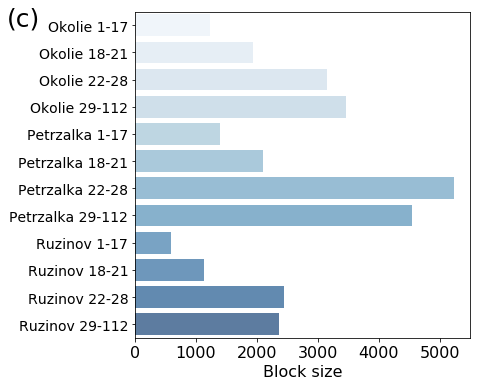

In [13]:
plt.figure(figsize=(6,6))
block_data['block_name_bar']=[ k.split('_')[0] + ' ' + k.split('_')[-1] for k in block_names ] 
sns.barplot(data=block_data,y='block_name_bar',x='block_size',palette='Blues',dodge=False,alpha=0.7)
plt.xlabel("Block size",fontsize=16)
plt.ylabel("")
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.text(-2100,0,'(c)',fontsize=25)
plt.savefig("Plots/block_sizes",bbox_inches='tight')

## Table of block ages for supplemet

In [14]:
from IPython.display import HTML
HTML(block_data.rename(columns={'block_name':'Block','block_size':'Size','average_age':'Mean age'})[['Block','Size']].to_html(index=False))

Block,Size
Okolie_ages_1-17,1234
Okolie_ages_18-21,1939
Okolie_ages_22-28,3154
Okolie_ages_29-112,3458
Petrzalka_ages_1-17,1398
Petrzalka_ages_18-21,2106
Petrzalka_ages_22-28,5234
Petrzalka_ages_29-112,4550
Ruzinov_ages_1-17,586
Ruzinov_ages_18-21,1123


In [16]:
block_names_newline = [k[0] for k in block_names]
Block_names_dict ={str(i):j for i,j in zip(list(coupling_graph.nodes()),block_names_newline)}

## Plot coupling graph between blocks

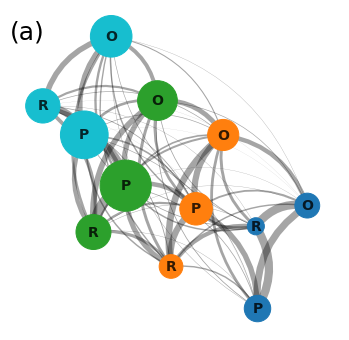

In [17]:
seed = 2 # Different seeds will give different spring layouts
random.seed(seed)
np.random.seed(seed)

pos = nx.spring_layout(coupling_graph)
edges = coupling_graph.edges()
weights = [ 10.0*coupling_graph[u][v]['weight'] for u,v in edges]
node_sizes = 0.5*np.asarray(block_sizes)

fig,ax = plt.subplots(figsize=(6,6))
# nx.draw_networkx_edges(coupling_graph,pos,width=weights,alpha=0.5) # For straigt edges

for index, name in enumerate(list(coupling_graph.nodes())):
    coupling_graph.add_node(name, pos=pos[name])
ax = plt.gca()
# Below adapted from:
# https://stackoverflow.com/questions/52588453/creating-curved-edges-with-networkx-in-python3
layout = pos
for index,edge in enumerate(edges):
    ax.annotate("",
                xy=layout[edge[0]], xycoords='data',
                xytext=layout[edge[1]], textcoords='data',zorder=1,
                arrowprops=dict(arrowstyle='-', color="0.0",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.3",lw=weights[index],alpha=0.35
                                ),
                )

nodes = nx.draw_networkx_nodes(coupling_graph,pos,node_color=age_field,node_size=node_sizes,cmap='tab10',alpha=1.0)
nodes.set_zorder(2)
labels=nx.draw_networkx_labels(coupling_graph,pos,labels=Block_names_dict,font_size=14,font_weight='bold',alpha=0.8)

ax.set_xlim(1.1*ax.get_xlim()[0],1.1*ax.get_xlim()[1])

plt.text(-1.15,0.6,'(a)',fontsize=25)

plt.axis('off')
plt.savefig("Plots/pokec_coupling_graph.jpg",bbox_inches='tight')